In [ ]:
%pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 20.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 104.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
zip_path = "/content/archive (3).zip"
extract_path = "/content/sar_dataset"

import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction completed!")


✅ Extraction completed!


In [ ]:
import os
import json

# ✅ Corrected dataset split and annotation path
dataset_split = 'train'
base_dir = f'/content/sar_dataset/SARscope/{dataset_split}'
annotation_file = os.path.join(base_dir, '_annotations.coco.json')  # confirmed path
image_dir = base_dir  # images are in the same folder

# Known corrupted image ID
faulty_image_id = 3736

# Loading annotation data
with open(annotation_file, 'r') as f:
    coco_data = json.load(f)

# Finding the filename of the faulty image
faulty_image = next((img for img in coco_data['images'] if img['id'] == faulty_image_id), None)

if faulty_image:
    faulty_filename = faulty_image['file_name']
    image_path = os.path.join(image_dir, faulty_filename)

    # Removing image file
    if os.path.exists(image_path):
        os.remove(image_path)
        print(f"✅ Removed image file: {faulty_filename}")
    else:
        print(f"⚠️ Image file not found: {faulty_filename}")

    # Removing image entry and related annotations from JSON
    coco_data['images'] = [img for img in coco_data['images'] if img['id'] != faulty_image_id]
    coco_data['annotations'] = [ann for ann in coco_data['annotations'] if ann['image_id'] != faulty_image_id]

    # Save updated annotations
    with open(annotation_file, 'w') as f:
        json.dump(coco_data, f)

    print("✅ Annotation file cleaned.")
else:
    print("⚠️ Image ID 3736 not found in annotations.")


✅ Removed image file: P0036_1200_2000_3600_4400_png.rf.e499cd87bc2ae09e75192dd84c702865.jpg
✅ Annotation file cleaned.


In [ ]:
import os
import json
from tqdm import tqdm

# --- Adjusting paths ---
splits = ['train', 'valid', 'test']
base_path = "/content/sar_dataset/SARscope"

for split in splits:
    print(f"🛠️ Converting annotations for: {split}")

    json_path = os.path.join(base_path, split, "_annotations.coco.json")
    image_dir = os.path.join(base_path, split)
    labels_dir = os.path.join(base_path, split, "labels")

    # label folder
    os.makedirs(labels_dir, exist_ok=True)

    with open(json_path) as f:
        data = json.load(f)

    # lookup tables
    images = {img['id']: img['file_name'] for img in data['images']}
    annotations = {}
    for ann in data['annotations']:
        image_id = ann['image_id']
        if image_id not in annotations:
            annotations[image_id] = []
        annotations[image_id].append(ann)

    # Converting each image's annotations to YOLO format
    for image_id, file_name in tqdm(images.items()):
        width = height = 640  # dataset uses resized 640x640 images
        label_path = os.path.join(labels_dir, file_name.replace('.jpg', '.txt'))

        with open(label_path, "w") as f:
            for ann in annotations.get(image_id, []):
                x, y, w, h = ann['bbox']
                xc = (x + w / 2) / width
                yc = (y + h / 2) / height
                w /= width
                h /= height
                class_id = ann['category_id'] - 1  # YOLO requires class_id starting from 0
                f.write(f"{class_id} {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

    print(f"✅ Finished converting {split}.")


🛠️ Converting annotations for: train


100%|██████████| 4716/4716 [00:00<00:00, 18937.98it/s]


✅ Finished converting train.
🛠️ Converting annotations for: valid


100%|██████████| 1346/1346 [00:00<00:00, 11551.93it/s]


✅ Finished converting valid.
🛠️ Converting annotations for: test


100%|██████████| 672/672 [00:00<00:00, 13905.69it/s]

✅ Finished converting test.


In [ ]:
# checking for directory
os.makedirs("/content/yolov8/data", exist_ok=True)

# YAML file
dataset_yaml = """
train: /content/sar_dataset/SARscope/train/images
val: /content/sar_dataset/SARscope/valid/images

nc: 1
names: ['ship']
"""

with open("/content/yolov8/data/sarscope.yaml", "w") as f:
    f.write(dataset_yaml)

print("✅ YOLO dataset config written to /content/yolov8/data/sarscope.yaml")


✅ YOLO dataset config written to /content/yolov8/data/sarscope.yaml


In [ ]:
import os
import shutil

# valid directory
valid_dir = '/content/sar_dataset/SARscope/valid'
images_dir = os.path.join(valid_dir, 'images')

# images directory
os.makedirs(images_dir, exist_ok=True)

# Moving all .jpg files from valid/ to valid/images/
for file in os.listdir(valid_dir):
    if file.endswith('.jpg'):
        src = os.path.join(valid_dir, file)
        dst = os.path.join(images_dir, file)
        shutil.move(src, dst)

print("✅ Moved validation images into valid/images/")


✅ Moved validation images into valid/images/


In [ ]:
import os
import shutil

train_dir = '/content/sar_dataset/SARscope/train'
images_dir = os.path.join(train_dir, 'images')

os.makedirs(images_dir, exist_ok=True)

# Moving all .jpg files from train/ to train/images/
for file in os.listdir(train_dir):
    if file.endswith('.jpg'):
        src = os.path.join(train_dir, file)
        dst = os.path.join(images_dir, file)
        shutil.move(src, dst)

print("✅ Moved training images into train/images/")

✅ Moved training images into train/images/


In [ ]:
test_dir = '/content/sar_dataset/SARscope/test'
images_dir = os.path.join(test_dir, 'images')

os.makedirs(images_dir, exist_ok=True)

# Moving all .jpg files from test/ to test/images/
for file in os.listdir(test_dir):
    if file.endswith('.jpg'):
        src = os.path.join(test_dir, file)
        dst = os.path.join(images_dir, file)
        shutil.move(src, dst)

print("✅ Moved training images into test/images/")

✅ Moved training images into test/images/


In [ ]:
from ultralytics import YOLO
model = YOLO("yolov8x.pt")  # Best YOLOV8 accuracy model


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 131M/131M [00:01<00:00, 128MB/s]


**Model Training**

In [ ]:
# Training the model
model.train(
    data="/content/yolov8/data/sarscope.yaml",
    epochs=10,
    imgsz=640,
    batch=16,
    name="yolov8_sarscope_x",
    project="/content/yolov8/runs/train",
)

Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/yolov8/data/sarscope.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/yolov8/runs/train, name=yolov8_sarscope_x, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, sh

100%|██████████| 755k/755k [00:00<00:00, 24.0MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              


  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics.nn.modules.conv.Conv             [640, 640, 3, 2]              
  8                  -1  3   6969600  ultralytics.nn.modules.block.C2f             [640, 640, 3, True]           
  9                  -1  1   1025920  ultralytics.nn.modules.block.SPPF            [640, 640, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   7379200  ultralytics.nn.modules.block.C2f             [1280, 640, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 14             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat           [1]  

100%|██████████| 5.35M/5.35M [00:00<00:00, 83.6MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1117.1±535.4 MB/s, size: 45.0 KB)


train: Scanning /content/sar_dataset/SARscope/train/labels... 4716 images, 0 backgrounds, 0 corrupt: 100%|██████████| 4716/4716 [00:01<00:00, 2535.49it/s]

train: New cache created: /content/sar_dataset/SARscope/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 995.5±570.6 MB/s, size: 41.4 KB)


val: Scanning /content/sar_dataset/SARscope/valid/labels... 1346 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1346/1346 [00:01<00:00, 1103.83it/s]

val: New cache created: /content/sar_dataset/SARscope/valid/labels.cache


Plotting labels to /content/yolov8/runs/train/yolov8_sarscope_x/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to /content/yolov8/runs/train/yolov8_sarscope_x
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      11.8G      1.561      1.463      1.242         21        640: 100%|██████████| 295/295 [06:15<00:00,  1.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:44<00:00,  1.03s/it]


                   all       1346       3781      0.583      0.342      0.363      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      12.3G      1.573      1.113      1.266         25        640: 100%|██████████| 295/295 [06:08<00:00,  1.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:43<00:00,  1.01s/it]

                   all       1346       3781      0.759      0.593      0.682      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      12.2G      1.498      1.021      1.223         20        640: 100%|██████████| 295/295 [06:04<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:43<00:00,  1.01s/it]

                   all       1346       3781        0.8       0.62      0.703      0.417



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      12.3G      1.414     0.9376      1.177         37        640: 100%|██████████| 295/295 [06:02<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:43<00:00,  1.01s/it]

                   all       1346       3781      0.807       0.65      0.743      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10        12G      1.342     0.8568      1.152         15        640: 100%|██████████| 295/295 [06:02<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:43<00:00,  1.01s/it]

                   all       1346       3781      0.837      0.692      0.784      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      12.3G      1.286     0.8268      1.126        208        640: 100%|██████████| 295/295 [06:01<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:43<00:00,  1.00s/it]

                   all       1346       3781      0.869      0.709      0.802      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      12.4G      1.251      0.778       1.11         23        640: 100%|██████████| 295/295 [06:00<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:43<00:00,  1.00s/it]

                   all       1346       3781      0.879      0.693       0.81      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      12.3G      1.203      0.732      1.088         24        640: 100%|██████████| 295/295 [06:01<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:43<00:00,  1.01s/it]

                   all       1346       3781      0.866      0.721      0.823      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      12.1G       1.15      0.692      1.066         21        640: 100%|██████████| 295/295 [06:01<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:43<00:00,  1.01s/it]

                   all       1346       3781      0.865      0.748       0.83      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      12.3G      1.115     0.6553       1.05         28        640: 100%|██████████| 295/295 [06:01<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:43<00:00,  1.00s/it]

                   all       1346       3781       0.88       0.76      0.854      0.563



10 epochs completed in 1.166 hours.
Optimizer stripped from /content/yolov8/runs/train/yolov8_sarscope_x/weights/last.pt, 136.7MB
Optimizer stripped from /content/yolov8/runs/train/yolov8_sarscope_x/weights/best.pt, 136.7MB

Validating /content/yolov8/runs/train/yolov8_sarscope_x/weights/best.pt...
Ultralytics 8.3.112 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 112 layers, 68,124,531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 43/43 [00:42<00:00,  1.01it/s]


                   all       1346       3781       0.88      0.761      0.854      0.563
Speed: 0.2ms preprocess, 27.4ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to /content/yolov8/runs/train/yolov8_sarscope_x


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ecef158f950>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

**Training Results Displayed**

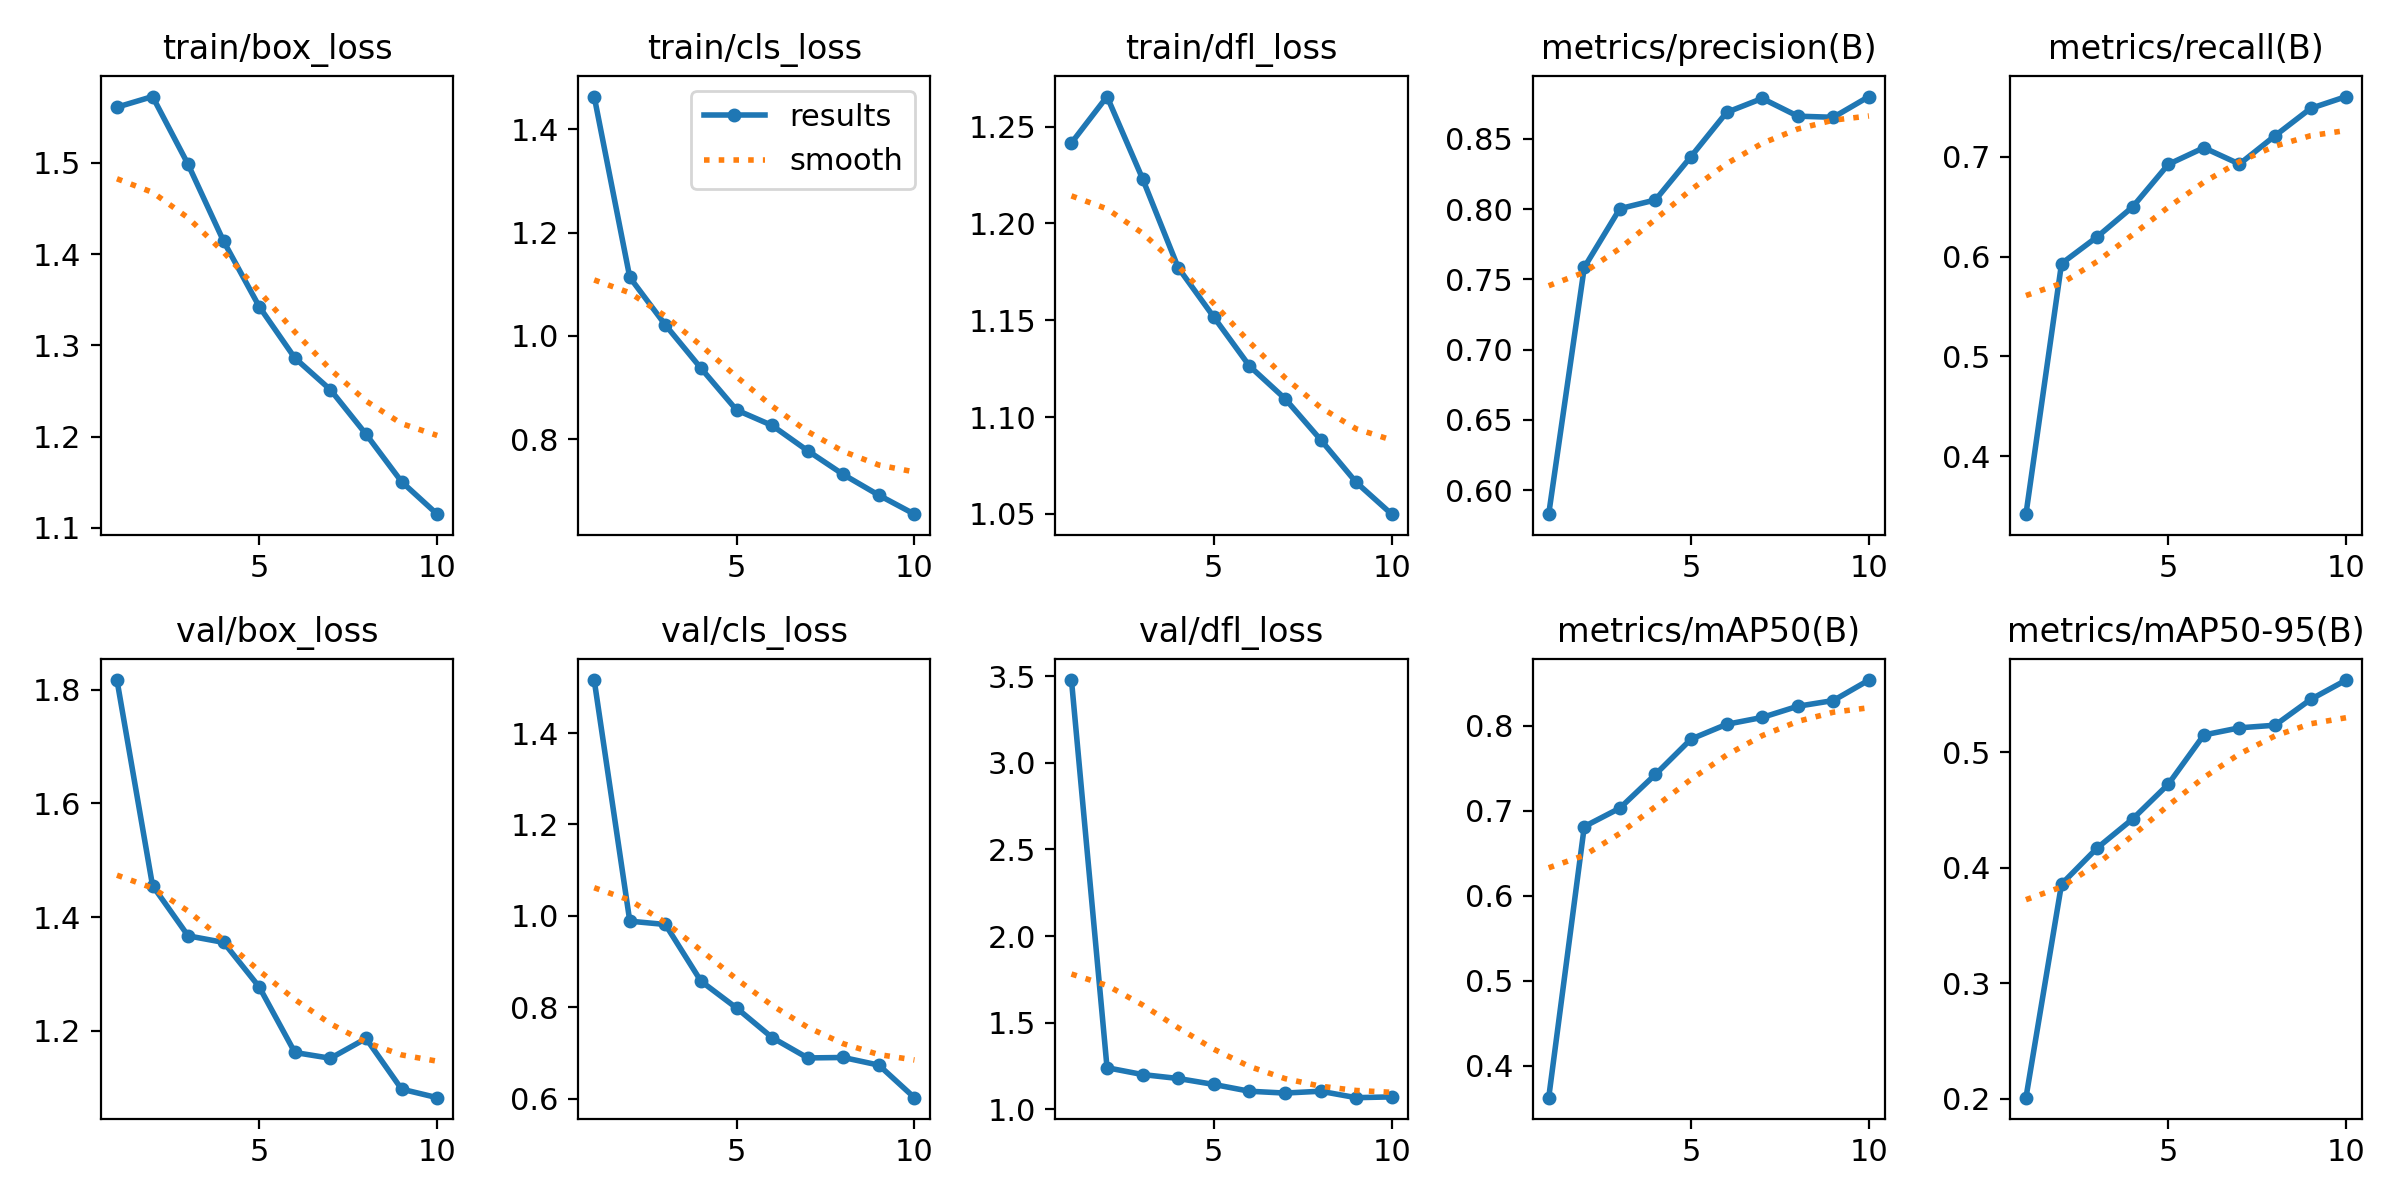

In [ ]:
from IPython.display import Image, display
display(Image(filename='/content/yolov8/runs/train/yolov8_sarscope_x/results.png', width=1000))

The training and validation losses show a consistent downward trend, indicating that the model is learning effectively without signs of overfitting. Both precision and recall improve steadily, with precision nearing 0.9 and recall above 0.75 by epoch 10. The mAP50 surpasses 0.85, and mAP50-95 crosses 0.55, suggesting strong detection accuracy and good generalization across different IoU thresholds. Overall, the YOLOv8x model demonstrates robust performance on the dataset.


**Running Inference on Test Images**

In [ ]:
# trained YOLOv8 model
model = YOLO("/content/yolov8/runs/train/yolov8_sarscope_x/weights/best.pt")

# Running inference on all test images
results = model.predict(
    source="/content/sar_dataset/SARscope/test/images",  # path to test images
    save=True,                                            # saving results with bounding boxes
    imgsz=640
)



image 1/672 /content/sar_dataset/SARscope/test/images/000003_jpg.rf.d35f1b3e7a2f971d5edb6bd95bdb0af4.jpg: 640x640 1 ship, 96.3ms
image 2/672 /content/sar_dataset/SARscope/test/images/000047_jpg.rf.a7c5a75819459815e026bd5f7c0c5d3d.jpg: 640x640 2 ships, 55.8ms
image 3/672 /content/sar_dataset/SARscope/test/images/000059_jpg.rf.e7369a146592d0d45241a640ac951d5c.jpg: 640x640 5 ships, 56.2ms
image 4/672 /content/sar_dataset/SARscope/test/images/000062_jpg.rf.74c3c4bcb7a59fb971a4bbe573235055.jpg: 640x640 2 ships, 56.8ms
image 5/672 /content/sar_dataset/SARscope/test/images/000069_jpg.rf.34afecb18bccfc3ce078330ec0d18094.jpg: 640x640 3 ships, 58.4ms
image 6/672 /content/sar_dataset/SARscope/test/images/000086_jpg.rf.bbc50f90494434e8ea43df96263ff54a.jpg: 640x640 1 ship, 55.7ms
image 7/672 /content/sar_dataset/SARscope/test/images/000096_jpg.rf.2ceab787373bba737023b8fced5b2cb0.jpg: 640x640 1 ship, 55.6ms
image 8/672 /content/sar_dataset/SARscope/test/images/000097_jpg.rf.7ee59769af8798229e374397

**Visualizing Sample Predictions**

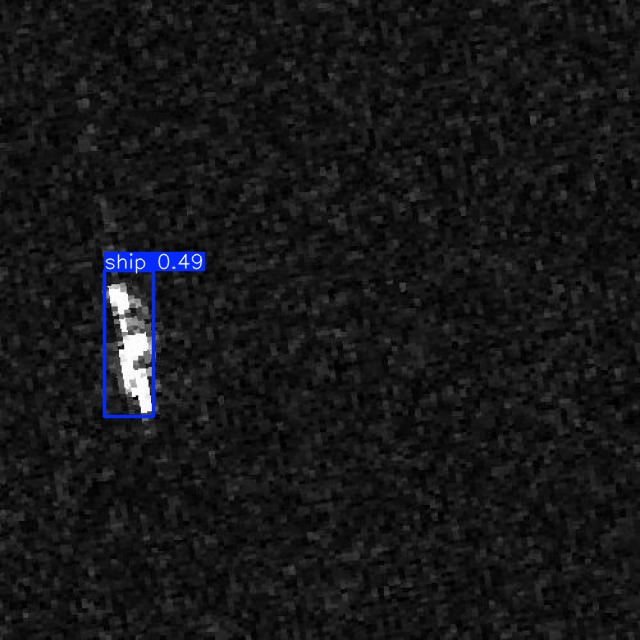

In [ ]:
from IPython.display import Image, display

# Display one prediction image
display(Image(filename="/content/runs/detect/predict/000003_jpg.rf.d35f1b3e7a2f971d5edb6bd95bdb0af4.jpg", width=300))


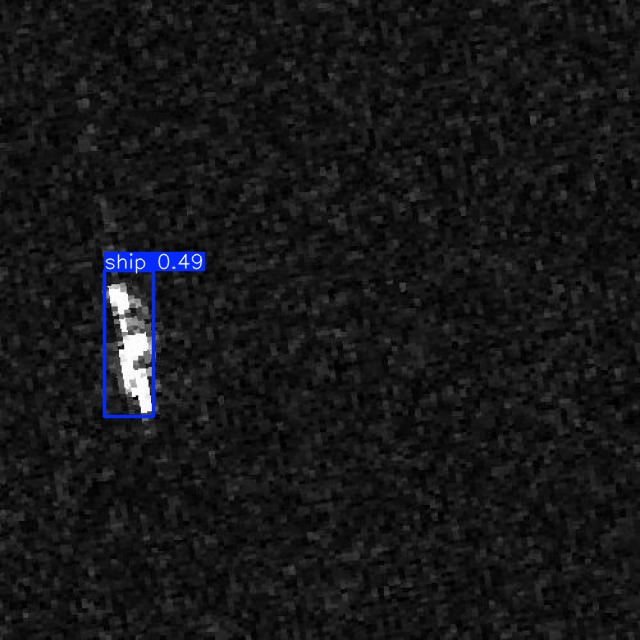

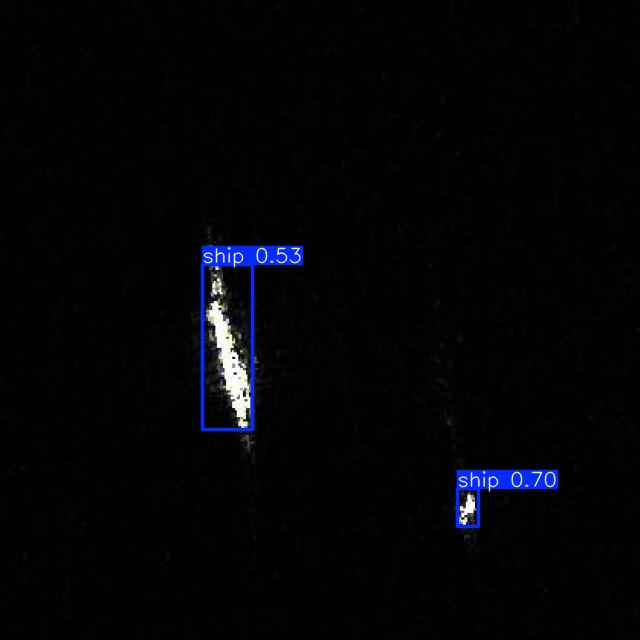

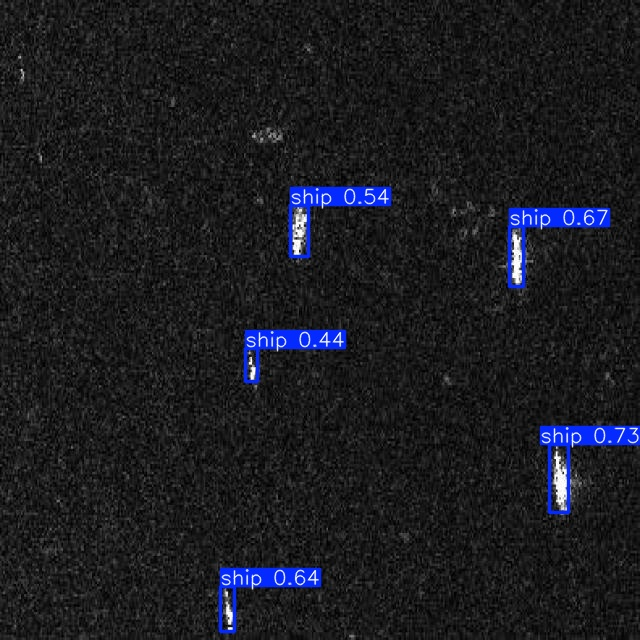

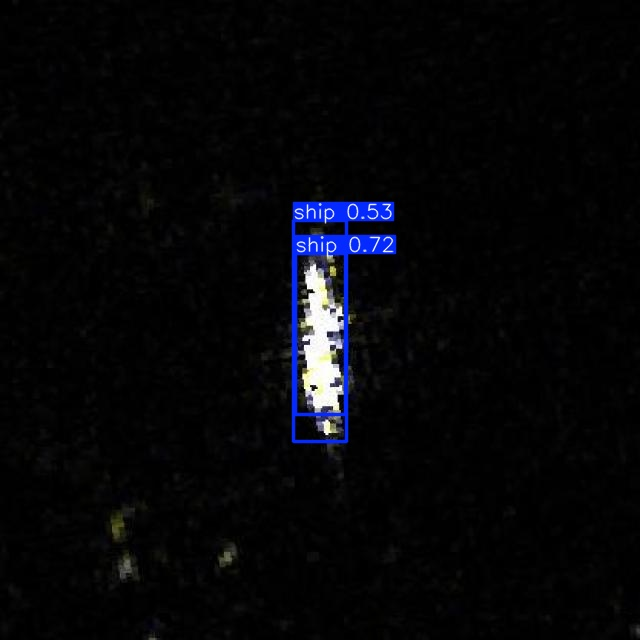

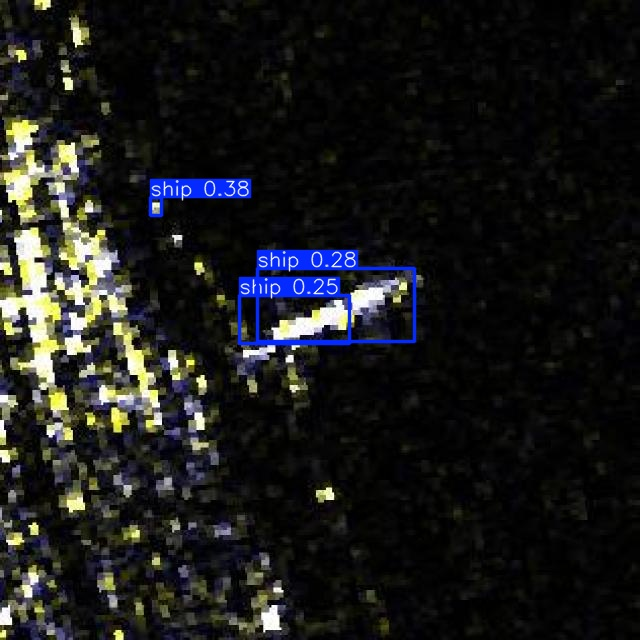

In [ ]:
"""
Displaying the first five prediction images produced by the YOLOv8x model.
These visuals show the actual detections on test images, helping verify the model's effectiveness
in identifying objects—in this case, ships—with bounding boxes and confidence scores.
It provides a qualitative check to complement the earlier quantitative metrics.
"""

import os
from IPython.display import Image, display

predict_dir = "/content/runs/detect/predict"
image_files = sorted(os.listdir(predict_dir))[:5]  # show first 5 results

for img_file in image_files:
    if img_file.endswith(".jpg"):
        display(Image(filename=os.path.join(predict_dir, img_file), width=300))
